# Netflix movie dataset

A ideia deste projeto é analisar o dataset [Latest Netflix data with 26+ joined attributes](https://www.kaggle.com/ashishgup/netflix-rotten-tomatoes-metacritic-imdb), encontrando correlações interessantes entre as *features* em questão e prever o *Hidden Gem Score* (ou até mesmo criar um novo score para medir esse aspecto). Abaixo, algumas ideias que tivemos em nossa primeira reunião:

## Ideias

- Nro de views do trailer
- Nro de likes/dislikes do trailer
- Grafos dos atores
- Boxoffice = bilheteria
- mapa com países e scores?
- talvez extrair algumas features das imagens?
- se a capa é muito colorida, se tem muita mudança de cor(?), se é mais clean, etc.


Primeiro, vamos importar o dataset para analisar os campos fornecidos.

In [10]:
import pandas as pd

filmes = pd.read_csv('https://raw.githubusercontent.com/hype-usp/Grupos-de-estudos/main/Latest%20Netflix%20data/netflix-rotten-tomatoes-metacritic-imdb.csv')

filmes.head()

,Title,Genre,Tags,Languages,Series or Movie,Hidden Gem Score,Country Availability,Runtime,Director,Writer,Actors,View Rating,IMDb Score,Rotten Tomatoes Score,Metacritic Score,Awards Received,Awards Nominated For,Boxoffice,Release Date,Netflix Release Date,Production House,Netflix Link,IMDb Link,Summary,IMDb Votes,Image,Poster,TMDb Trailer,Trailer Site
0,Lets Fight Ghost,"Crime, Drama, Fantasy, Horror, Romance","Comedy Programmes,Romantic TV Comedies,Horror ...","Swedish, Spanish",Series,4.3,Thailand,< 30 minutes,Tomas Alfredson,John Ajvide Lindqvist,"Kåre Hedebrant, Per Ragnar, Lina Leandersson, ...",R,7.9,98.0,82.0,74.0,57.0,"$2,122,065",12 Dec 2008,2021-03-04,"Canal+, Sandrew Metronome",https://www.netflix.com/watch/81415947,https://www.imdb.com/title/tt1139797,A med student with a supernatural gift tries t...,205926.0,https://occ-0-4708-64.1.nflxso.net/dnm/api/v6/...,https://m.media-amazon.com/images/M/MV5BOWM4NT...,NaN,NaN
1,HOW TO BUILD A GIRL,Comedy,"Dramas,Comedies,Films Based on Books,British",English,Movie,7.0,Canada,1-2 hour,Coky Giedroyc,Caitlin Moran,"Paddy Considine, Cleo, Beanie Feldstein, Dónal...",R,5.8,79.0,69.0,1.0,NaN,"$70,632",08 May 2020,2021-03-04,"Film 4, Monumental Pictures, Lionsgate",https://www.netflix.com/watch/81041267,https://www.imdb.com/title/tt4193072,"When nerdy Johanna moves to London, things get...",2838.0,https://occ-0-1081-999.1.nflxso.net/dnm/api/v6...,https://m.media-amazon.com/images/M/MV5BZGUyN2...,https://www.youtube.com/watch?v=eIbcxPy4okQ,YouTube
2,Centigrade,"Drama, Thriller",Thrillers,English,Movie,6.4,Canada,1-2 hour,Brendan Walsh,"Brendan Walsh, Daley Nixon","Genesis Rodriguez, Vincent Piazza",Unrated,4.3,NaN,46.0,NaN,NaN,"$16,263",28 Aug 2020,2021-03-04,NaN,https://www.netflix.com/watch/81305978,https://www.imdb.com/title/tt8945942,"Trapped in a frozen car during a blizzard, a p...",1720.0,https://occ-0-1081-999.1.nflxso.net/dnm/api/v6...,https://m.media-amazon.com/images/M/MV5BODM2MD...,https://www.youtube.com/watch?v=0RvV7TNUlkQ,YouTube
3,ANNE+,Drama,"TV Dramas,Romantic TV Dramas,Dutch TV Shows",Turkish,Series,7.7,"Belgium,Netherlands",< 30 minutes,NaN,NaN,"Vahide Perçin, Gonca Vuslateri, Cansu Dere, Be...",NaN,6.5,NaN,NaN,1.0,NaN,NaN,01 Oct 2016,2021-03-04,NaN,https://www.netflix.com/watch/81336456,https://www.imdb.com/title/tt6132758,"Upon moving into a new place, a 20-something r...",1147.0,https://occ-0-1489-1490.1.nflxso.net/dnm/api/v...,https://m.media-amazon.com/images/M/MV5BNWRkMz...,NaN,NaN
4,Moxie,"Animation, Short, Drama","Social Issue Dramas,Teen Movies,Dramas,Comedie...",English,Movie,8.1,"Lithuania,Poland,France,Iceland,Italy,Spain,Gr...",1-2 hour,Stephen Irwin,NaN,Ragga Gudrun,NaN,6.3,NaN,NaN,NaN,4.0,NaN,22 Sep 2011,2021-03-04,NaN,https://www.netflix.com/watch/81078393,https://www.imdb.com/title/tt2023611,Inspired by her moms rebellious past and a con...,63.0,https://occ-0-4039-1500.1.nflxso.net/dnm/api/v...,https://m.media-amazon.com/images/M/MV5BODYyNW...,NaN,NaN


Para facilitar o trabalho com os dados, vamos fazer um pré-processamento em 2 fases: estrutural (formatação de strings, datas, números, etc) e de qualidade (valores faltantes, normalização, one hot encoding, etc).

## Pré-processamento estrutural

Campos como "Genre", "Tags" e "Actors" possuem categorias diferentes em uma única string. Por isso, vamos processar essas colunas para transformar a string numa lista de strings (fazendo o split na vírgula).

In [11]:
#@title Pré-processamento de categorias com vírgula
def split_list(t):
  if str(t) == t:
    return t.split(',')
  else:
    return t

filmes['Genre'] = filmes['Genre'].apply(split_list)
filmes['Tags'] = filmes['Tags'].apply(split_list)
filmes['Languages'] = filmes['Languages'].apply(split_list)
filmes['Country Availability'] = filmes['Country Availability'].apply(split_list)
filmes['Actors'] = filmes['Actors'].apply(split_list)
filmes['Production House'] = filmes['Production House'].apply(split_list)

filmes = filmes.convert_dtypes()

Agora, vamos conferir novamente se os tipos de dados de cada coluna condizem com os dados da coluna. Abaixo, vemos os tipos do dataframe (apenas nossas colunas que possuem listas devem estar como "object").

In [12]:
filmes.dtypes

Title                     string
Genre                     object
Tags                      object
Languages                 object
Series or Movie           string
Hidden Gem Score         float64
Country Availability      object
Runtime                   string
Director                  string
Writer                    string
Actors                    object
View Rating               string
IMDb Score               float64
Rotten Tomatoes Score      Int64
Metacritic Score           Int64
Awards Received            Int64
Awards Nominated For       Int64
Boxoffice                 string
Release Date              string
Netflix Release Date      string
Production House          object
Netflix Link              string
IMDb Link                 string
Summary                   string
IMDb Votes                 Int64
Image                     string
Poster                    string
TMDb Trailer              string
Trailer Site              string
dtype: object

Ainda precisamos arrumar a coluna `Boxoffice`, que deve estar formatada como um valor monetário, ou seja, `float`, mas está como string (por causa do caracter de dólar), e as colunas de data (`Release Date` e `Netflix Release Date`), que devem estar como datetime mas estão também como string.

In [13]:
#@title Pré-processamento de datas e valores monetários
# ajustando datas
filmes['Release Date'] = pd.to_datetime(filmes['Release Date'], infer_datetime_format=True)
filmes['Netflix Release Date'] = pd.to_datetime(filmes['Netflix Release Date'], infer_datetime_format=True)

# ajustando dinheiro
import re
def split_money(t):
  if type(t) == str:
    return float(re.sub(',', '', t.split('$')[1]))
  else:
    return float('NaN')

filmes['Boxoffice'] = filmes['Boxoffice'].apply(split_money)

Conferindo uma última vez:

In [14]:
filmes.dtypes

Title                            string
Genre                            object
Tags                             object
Languages                        object
Series or Movie                  string
Hidden Gem Score                float64
Country Availability             object
Runtime                          string
Director                         string
Writer                           string
Actors                           object
View Rating                      string
IMDb Score                      float64
Rotten Tomatoes Score             Int64
Metacritic Score                  Int64
Awards Received                   Int64
Awards Nominated For              Int64
Boxoffice                       float64
Release Date             datetime64[ns]
Netflix Release Date     datetime64[ns]
Production House                 object
Netflix Link                     string
IMDb Link                        string
Summary                          string
IMDb Votes                        Int64


E agora podemos seguir para o pré-processamento de qualidade dos dados.

## Pré-processamento de qualidade

Vamos primeiro tratar os valores faltantes do conjunto de dados. Para isso, vamos olhar para as colunas que apresentam algum valor nulo e sua porcentagem:

In [15]:
missing_perc = filmes.isnull().sum() * 100 / len(filmes)
filmes_missing = pd.DataFrame({'column_name': filmes.columns, 'missing_perc': missing_perc})
filmes_missing.loc[filmes_missing.missing_perc > 0].sort_values(by='missing_perc', ascending=False)

,column_name,missing_perc
Boxoffice,Boxoffice,74.114987
Metacritic Score,Metacritic Score,71.989664
Production House,Production House,66.737726
Awards Received,Awards Received,60.755814
Rotten Tomatoes Score,Rotten Tomatoes Score,58.772610
TMDb Trailer,TMDb Trailer,53.527132
Trailer Site,Trailer Site,53.527132
Awards Nominated For,Awards Nominated For,50.510336
View Rating,View Rating,45.374677
Director,Director,30.413437


Para cada coluna, vamos tentar entender o motivo de os dados estarem faltando e determinar o tratamento que daremos aos valores nulos. Vamos começar pelas mais preenchidas, pois nosso trabalho será mais fácil com elas.

- `Runtime`: Tempo de duração do título. 
  - **Diagnóstico:** Certamente, esse dado existe. Olhando no conjunto de dados, no entanto, vemos que apenas um título apresenta Runtime nulo. Entrando no site do IMDB, vemos que essa informação está disponível, e o título tem duração de 30 minutos.  
  - **Tratamento**: Preencher o valor no próprio dataset.

- `Summary`: Sinopse do título.
  - **Diagnóstico:** Provavelmente o título tem uma sinopse, mas não temos informações suficientes para determinar a causa. Dependendo do uso que faremos dessa variável poderemos preenchê-la de formas diferentes. Aqui consideraremos que é uma descrição textual do título, e o que temos de mais próximo é o nome.
  - **Tratamento:** Preencher com o nome do título.

- `Country Availability`: Países em que o título está disponível.
  - **Diagnóstico:** O título pode ter sido desativado, mas ainda sim queremos o preenchimento dessa variável. Podemos utilizar os idiomas em que o título está disponível para nos ajudar. No gráfico abaixo, vemos os pares Idioma,País mais populares, e abaixo dele, os países mais populares para cada idioma.
  - **Tratamento:** Incluiremos os países mais populares para cada idioma disponível, de acordo com o segundo gráfico. Caso não seja encontrado, incluiremos o país mais popular (a moda). OBS.: Como vamos usar a coluna Language, é muito importante que esta coluna seja tratada *após* tratarmos a coluna Language.

 


In [16]:
#@title Criação de contador para plotar o gráfico
from collections import Counter
langs = [re.sub(' ', '', i) for i in filmes['Languages'].fillna('').apply(','.join)]
counts = [re.sub(' ', '', i) for i in filmes['Country Availability'].fillna('').apply(','.join)]

langcounts = []

for i in range(len(langs)):
  for l in langs[i].split(','):
    if l != '':
      [langcounts.append(l+','+c) for c in counts[i].split(',')]

langcounts = Counter(langcounts)
counts = langcounts.most_common(5000)

import plotly.express as px
fig = px.bar(x=[i for i,j in counts], y=[j for i,j in counts], title='Contagem de idiomas e país de disponibilidade')
fig.show()

In [17]:
#@title Criação de contador para plotar o gráfico
max_counts = []

for l in langcounts.most_common(5000):
  if len(max_counts) > 0:
    if l[0].split(',')[0] not in [i.split(',')[0] for i,j in max_counts]:
      max_counts.append(l)
  else:
    max_counts.append(l)

fig = px.bar(x=[i for i,j in max_counts], y=[j for i,j in max_counts], title='Contagem de idiomas e país mais popular de disponibilidade')
fig.show()

`Tags`: Categorias específicas do título.  
  - **Diagnóstico:** O título pode não ter uma descrição mais aprofundada acerca de categorias. O mais próximo que temos disso são as categorias de gênero.
  - **Tratamento:** Preencher com as categorias do gênero. OBS.: Novamente, é muito importante que tratemos a coluna Genre antes da coluna Tags.

`Genre`: Gênero do título.
  - **Diagnóstico:** Ou é uma falha na criação do dataset, ou não foi possível categorizar o título. Em alguns casos, o título possui Tags mas não possui gênero. Neste caso, é provavelmente uma falha, mas no caso em que o título não tem nem Tags e nem Genre, faz mais sentido deixar uma lista vazia no lugar.
  - **Tratamento:** Se a coluna Tags não for nula, vamos replicá-la. Senão, deixaremos uma lista vazia.

`Actors`: Atores que trabalharam no projeto.
   - **Diagnóstico:** Alguns títulos são documentários, mas mesmo assim, não faz sentido um título não ter atores. No entanto, como não temos informações o suficiente, vamos manter como uma lista vazia.
   - **Tratamento:** Lista vazia.

`Languages`: Idiomas em que o título está disponível.
  - **Diagnóstico:** Provavelmente, um erro na criação da base. 
  - **Tratamento:** Podemos nos basear no Country Availability, quando este não for nulo, para preencher esta coluna com os idiomas mais populares falados em cada país. Caso este não esteja preenchido, vamos preencher com a moda (idioma mais falado).

`IMDb Score`: Pontuação no IMDB.
  - **Diagnóstico:** Talvez o título não esteja no IMDB.
  - **Tratamento:** Como a distribuição de valores, mostrada abaixo, é aproximadamente normal, podemos utilizar a média.

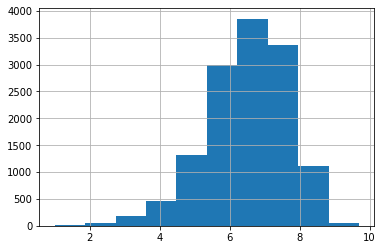

In [18]:
filmes['IMDb Score'].hist()

`Hidden Gem Score`: Pontuação que estamos tentando prever ou melhorar.
  - **Diagnóstico:** Erro na criação da base.
  - **Tratamento:** Chorar! \o/


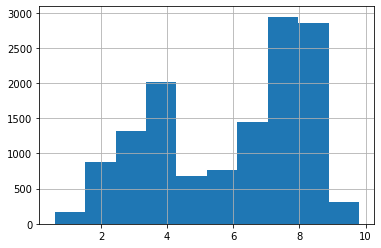

In [19]:
filmes['Hidden Gem Score'].hist()

`IMDb Votes`: Votos do título no IMDB.
  - **Diagnóstico:** O título pode não estar no IMDB ou pode não ter votos.
  - **Tratamento:** Mediana (possui outliers).

In [20]:
fig = px.box(filmes['IMDb Votes'].fillna(0), y='IMDb Votes')
fig.show()

In [21]:
filmes[filmes['IMDb Votes'] >= 2000000]

,Title,Genre,Tags,Languages,Series or Movie,Hidden Gem Score,Country Availability,Runtime,Director,Writer,Actors,View Rating,IMDb Score,Rotten Tomatoes Score,Metacritic Score,Awards Received,Awards Nominated For,Boxoffice,Release Date,Netflix Release Date,Production House,Netflix Link,IMDb Link,Summary,IMDb Votes,Image,Poster,TMDb Trailer,Trailer Site
14331,Inception,"[Action, Adventure, Sci-Fi, Thriller]","[Thrillers, Award-winning Movies, Academy Awar...","[English, Japanese, French]",Movie,4.2,"[Hungary, France, Romania, Belgium, Switzerlan...",> 2 hrs,Christopher Nolan,Christopher Nolan,"[Joseph Gordon-Levitt, Leonardo DiCaprio, El...",PG-13,8.8,87,74,156,218,292576195.0,2010-07-16,2015-04-14,"[Warner Bros., Syncopy]",https://www.netflix.com/watch/70131314,https://www.imdb.com/title/tt1375666,"In this mindbending sci-fi thriller, a man run...",2072912,https://occ-0-2851-38.1.nflxso.net/dnm/api/v6/...,https://images-na.ssl-images-amazon.com/images...,https://www.youtube.com/watch?v=Jvurpf91omw,YouTube
14478,The Dark Knight,"[Action, Crime, Drama, Thriller]","[Award-winning Movies, Academy Award-Winning F...","[English, Mandarin]",Movie,4.5,"[Russia, Lithuania, France, Romania, Belgium, ...",> 2 hrs,Christopher Nolan,"Jonathan Nolan, David S. Goyer, Christopher No...","[Michael Caine, Christian Bale, Aaron Eckhar...",PG-13,9.0,94,84,158,163,534858444.0,2008-07-18,2015-04-14,[Syncopy],https://www.netflix.com/watch/70079583,https://www.imdb.com/title/tt0468569,"As Batman, Lt. Gordon and the district attorne...",2308981,https://occ-0-2851-38.1.nflxso.net/dnm/api/v6/...,https://images-na.ssl-images-amazon.com/images...,https://www.youtube.com/watch?v=kmJLuwP3MbY,YouTube
14621,The Shawshank Redemption,[Drama],"[Dramas, 20th Century Period Pieces, Dramas ba...",[English],Movie,4.4,"[France, Portugal, Belgium, Switzerland, Japan...",> 2 hrs,Frank Darabont,"Frank Darabont, Stephen King","[Tim Robbins, Morgan Freeman, William Sadler...",R,9.3,91,80,21,43,28699976.0,1994-10-14,2015-04-14,"[Columbia Pictures, Castle Rock Entertainment]",https://www.netflix.com/watch/70005379,https://www.imdb.com/title/tt0111161,"Framed for murder, upstanding banker Andy Dufr...",2354197,https://occ-0-2773-2774.1.nflxso.net/dnm/api/v...,https://images-na.ssl-images-amazon.com/images...,https://www.youtube.com/watch?v=K_tLp7T6U1c,YouTube


`Release Date`: Data de lançamento do título.
  - **Diagnóstico:** Como ele tem uma data de lançamento na Netflix, obviamente essa informação existe, e apenas não foi incluída.
  - **Tratamento:** Data de lançamento na Netflix.

`IMDb Link`: Link do IMDb.
  - **Diagnóstico:** Talvez o título não esteja no IMDb. Não temos informações o suficiente para preencher.
  - **Tratamento:** String vazia.

`Poster`: Capa do título.
  - **Diagnóstico:** Como todos os títulos possuem uma imagem, provavelmente a capa não foi incluída por um erro.
  - **Tratamento:** Utilizar a coluna Image.

`Writer`: Autor(a) do título.
  - **Diagnóstico:** Logicamente o título possui um(a) autor(a), então provavelmente foi um erro de preenchimento. Não temos informações o suficiente para preencher.
  - **Tratamento:** String vazia.

`Director`: Diretor(a) do título.
  - **Diagnóstico:** Novamente, provável erro de preenchimento, e não temos informações o suficiente para preencher.
  - **Tratamento:** String vazia.

`View Rating`: Classificação indicativa do título.
  - **Diagnóstico:** O dado existe, porém não está disponível. Como a base traz filmes de diferentes países com diferentes classificações, é ainda mais complicado utilizar essa variável. 
  - **Tratamento:** Por termos pouco mais da metade dos dados preenchidos, vamos utilizar a moda.

`Awards Nominated For`: Quantidade de nomeações para prêmios.
  - **Diagnóstico:** O conjunto de dados não possui nenhum valor 0. Portanto, é válido concluir que os títulos com este campo nulo receberam 0 nomeações.
  - **Tratamento:** Preencher valores nulos com 0.

`Awards Received`: Quantidade de premiações recebidas.
  - **Diagnóstico:** Mesma coisa do caso anterior.
  - **Tratamento:** Preencher valores nulos com 0.

Depois disso, todas as outras variáveis possuem menos de 50% de preenchimento, e por isso não vale a pena guardá-las.

Para além do preenchimento dos valores nulos, precisamos ainda escalar nossas variáveis numéricas. Como se vê na tabela abaixo, elas possuem escalas bem diferentes.

In [22]:
filmes.describe()

,Hidden Gem Score,IMDb Score,Rotten Tomatoes Score,Metacritic Score,Awards Received,Awards Nominated For,Boxoffice,IMDb Votes
count,13379.000000,13381.000000,6382.000000,4336.000000,6075.000000,7661.000000,4.007000e+03,1.337900e+04
mean,5.937551,6.496054,59.523034,56.813653,8.764444,13.983161,4.568229e+07,4.272841e+04
std,2.250202,1.146910,26.999173,17.582545,18.311171,29.821052,7.097634e+07,1.257012e+05
min,0.600000,1.000000,0.000000,5.000000,1.000000,1.000000,7.200000e+01,5.000000e+00
25%,3.800000,5.800000,38.000000,44.000000,1.000000,2.000000,7.816345e+05,4.035000e+02
50%,6.800000,6.600000,64.000000,57.000000,3.000000,5.000000,1.955107e+07,2.322000e+03
75%,7.900000,7.300000,83.000000,70.000000,8.000000,12.000000,5.969536e+07,2.089050e+04
max,9.800000,9.700000,100.000000,100.000000,300.000000,386.000000,6.593639e+08,2.354197e+06


In [24]:
!pip install pyvis

In [44]:
import networkx as nx

language_network = pd.DataFrame([[l.split(',')[0], l.split(',')[1]] for l in langcounts.keys()], columns=['Source', 'Target'])
language_network['Weight'] = langcounts.values()
language_network = language_network[:50]

G = nx.from_pandas_edgelist(language_network, source='Source', target='Target', edge_attr='Weight')

from pyvis.network import Network

net = Network(notebook=True)
net.from_nx(G)

from IPython.core.display import display, HTML

net.show('network.html')
net.toggle_physics(False)
display(HTML('network.html'))

In [30]:
import networkx as nx

language_network = pd.DataFrame([[l[0].split(',')[0], l[0].split(',')[1], l[1]] for l in max_counts], columns=['Source', 'Target', 'Weight'])
G = nx.from_pandas_edgelist(language_network, source='Source', target='Target', edge_attr='Weight')

from pyvis.network import Network

net = Network(notebook=True)
net.from_nx(G)

from IPython.core.display import display, HTML

net.show('network.html')
display(HTML('network.html'))